In [168]:
import numpy as np
import pandas as pd
import astroquery
import matplotlib.pyplot as plt
import glob

from numpy.random import poisson, beta, uniform

import occSimFuncs as occFunc

%matplotlib inline

In [169]:
msun = 1.9891E30
rsun = 695500000.
G = 6.67384E-11
AU = 149597870700.

consts = {'sigma_threshold': 7.5}

In [170]:
def make_allplanets_df_vec(df,starid_zp):
    # lets refector the above code to make it array operations
    totalRows = df.loc[:, 'Nplanets'].sum()

    df.loc[:, 'planetRadius'] = pd.Series()
    df.loc[:, 'planetPeriod'] = pd.Series()
    df.loc[:, 'starID'] = pd.Series()

    radper_dressing = occFunc.Dressing15_select(totalRows)
    radper_fressin = occFunc.Fressin13_select(totalRows)

    #we need an array of indices
    totalRows = df.loc[:, 'Nplanets'].sum()
    rowIdx = np.repeat(np.arange(df.shape[0]),np.array(df.Nplanets.values))

    newdf = df.iloc[rowIdx]
    newdf.loc[:, 'starID'] = rowIdx + starid_zp


    newdf.loc[:,'planetRadius'] = np.where(newdf.isMdwarf,radper_dressing[0],radper_fressin[0])
    newdf.loc[:,'planetPeriod'] = np.where(newdf.isMdwarf,radper_dressing[1],radper_fressin[1])
    newdf.set_index(np.arange(newdf.shape[0]), inplace=True)

    return newdf, newdf.starID.iloc[-1]

We are going to load real stars from the TIC and put planets around these and see how many we can detect

In [4]:
# load the targets
fn = '../data/selected.csv.bz2'
df = pd.read_csv(fn)

/Users/tom/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [79]:
# some things we are going to need later
df['isMdwarf'] = np.where((df.TEFF < 3900) & (df.RADIUS < 0.5), True, False)
df['isGiant'] = np.ones(df.shape[0], dtype='bool') # assume all dwarfs

df['tess_ccd'] = np.zeros(df.shape[0], dtype='int') 
df['tess_ccd'] = np.where((np.abs(df.ECLAT) >= 6) & (np.abs(df.ECLAT) < 30), 1, df.tess_ccd)
df['tess_ccd'] = np.where((np.abs(df.ECLAT) >= 30) & (np.abs(df.ECLAT) < 54), 2, df.tess_ccd)
df['tess_ccd'] = np.where((np.abs(df.ECLAT) >= 54) & (np.abs(df.ECLAT) < 78), 3, df.tess_ccd)
df['tess_ccd'] = np.where((np.abs(df.ECLAT) >= 78) & (np.abs(df.ECLAT) < 90), 4, df.tess_ccd) # spins on axis

# there are some dodgy assumptions here, which we can fix later
# we probably want to use tvguide
df['obs_len'] = np.zeros(df.shape[0], dtype='int') 
df['obs_len'] =  np.where(df.tess_ccd == 1, 27, df.obs_len)
df['obs_len'] =  np.where(df.tess_ccd == 4, 351, df.obs_len)

# ccd 2 and 3 are harder, we are going to do something stupid and wrong for now
df['obs_len'] =  np.where(df.tess_ccd == 2, 27, df.obs_len)
df['obs_len'] =  np.where(df.tess_ccd == 2, 54, df.obs_len)

# this cosi will be the same for every planet in the system
df['cosi'] = pd.Series(np.random.random(size=df.shape[0]),name='cosi')

df['noise_level'] = occFunc.TESS_noise_1h(df.TESSMAG)

In [80]:
# how many planets should each star get
np_fgk = poisson(lam=0.689,size=df.shape[0])
np_m = poisson(lam=2.5,size=df.shape[0])
df['Nplanets'] = pd.Series(np.where(df.isMdwarf, np_m, np_fgk), name='Nplanets')

In [81]:
# draw a bunch of planest and accociate them with each star
starID = 0 # ???
newDF, starID = make_allplanets_df_vec(df, starID)

# get some transit epochs
newDF = newDF.assign(T0=pd.Series(uniform(0, 1, size=newDF.shape[0]) * newDF.loc[:, 'planetPeriod']))

#calculate the number of transits
nt1 = np.floor(newDF['obs_len'] / newDF.planetPeriod)
newDF['Ntransits'] = np.where(newDF['T0'] < newDF['obs_len'] % newDF.planetPeriod, nt1+1,nt1)
newDF['ars'] = occFunc.per2ars(newDF.planetPeriod, newDF.MASS, newDF.RADIUS)
newDF['ecc'] = pd.Series(beta(1.03,13.6,size=newDF.shape[0]),name='ecc', ) # ecc dist from Van Eylen 2015
newDF['omega'] = pd.Series(uniform(-np.pi,np.pi,size=newDF.shape[0]),name='omega')
newDF['rprs'] = occFunc.get_rprs(newDF.planetRadius, newDF.RADIUS)
newDF['impact'] = newDF.cosi * newDF.ars * ((1-newDF.ecc**2)/1+newDF.ecc*np.sin(newDF.omega)) # cite Winn
newDF['duration'] = occFunc.get_duration(newDF.planetPeriod, newDF.ars, cosi=newDF.cosi, b=newDF.impact,
                                rprs=newDF.rprs) # cite Winn
newDF['duration_correction'] = np.sqrt(newDF.duration * 24.) # correction for CDPP because transit dur != 1 hour
newDF['transit_depth']  = occFunc.get_transit_depth(newDF.planetRadius, newDF.RADIUS)

newDF['transit_depth_diluted']  = newDF['transit_depth'] / (1+newDF.CONTRATIO)

/Users/tom/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/Users/tom/gitcode/tyieldsim/code/occSimFuncs.py:27: RuntimeWarning: invalid value encountered in sqrt
  part3 = np.sqrt((1 + rprs)**2 - b**2)


In [102]:
# now lets see if those planets are detected
newDF['needed_for_detection'] = (newDF.transit_depth_diluted * newDF.duration_correction *
                    np.sqrt(newDF.Ntransits)) / consts['sigma_threshold']

newDF['has_transits']  = (newDF.ars > 1.0) & (newDF.impact < 1.0)

In [103]:
newDF['detected'] = (newDF.noise_level < newDF.needed_for_detection) & (newDF.Ntransits >= 3) & (newDF.planetRadius > 0.0) & newDF.has_transits


total_planets = newDF.detected.sum()

In [104]:
total_planets

738

In [85]:
detected_DF = newDF[newDF.detected == True]

(array([  10.,  163.,  180.,  163.,   25.,   44.,   11.,   19.,   16.]),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 9 Patch objects>)

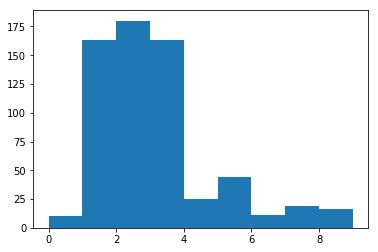

In [96]:
plt.hist(detected_DF.planetRadius, bins=np.arange(0,10,1))

(array([ 479.,  145.,   50.,   16.,   16.,    8.,    8.,    9.,    6.,    0.]),
 array([  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100]),
 <a list of 10 Patch objects>)

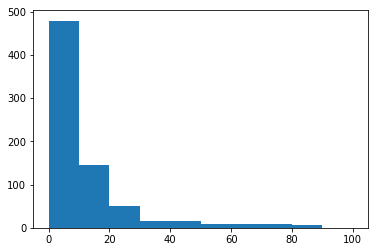

In [97]:
plt.hist(detected_DF.planetPeriod, np.arange(0,110,10))

(array([  19.,  114.,   89.,   56.,   43.,   16.,   25.,   33.,   44.,
          71.,   76.,   73.,   38.,   16.,    7.,    8.,    2.,    1.,
           1.,    2.,    1.,    1.,    2.,    0.,    0.,    0.,    0.,
           0.,    0.]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,
         1.1,  1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ,  2.1,
         2.2,  2.3,  2.4,  2.5,  2.6,  2.7,  2.8,  2.9]),
 <a list of 29 Patch objects>)

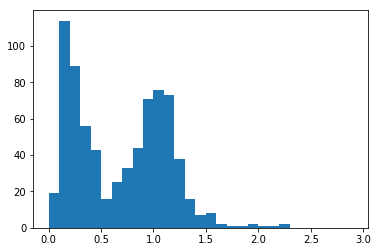

In [98]:
plt.hist(detected_DF.RADIUS, np.arange(0,3,0.1))

(array([ 5239.,  2093.,  1136.,   781.,   529.,   431.,   277.,   225.,
          208.,   165.,   132.,   117.,    99.,    80.,    85.,    66.,
           46.,    38.,    35.]),
 array([ 0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,
         5.5,  6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5]),
 <a list of 19 Patch objects>)

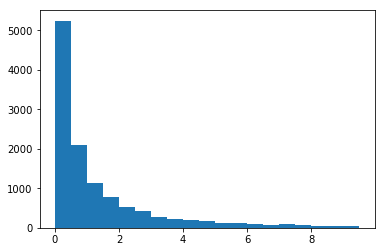

In [114]:
q = (newDF.transit_depth_diluted * newDF.duration_correction *
                    np.sqrt(newDF.Ntransits)) / newDF.noise_level

plt.hist(q[np.isfinite(q)]  , np.arange(0,10,0.5))

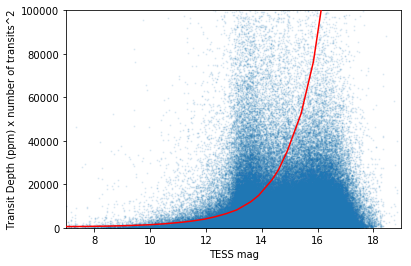

In [148]:
mag_level, noise_level = np.genfromtxt('TessNoise_1h.csv', delimiter=',',
                                           unpack=True,
                                           comments='#')

plt.scatter(newDF.TESSMAG, newDF.transit_depth_diluted * np.sqrt(newDF.obs_len / newDF.planetPeriod),  s=1, alpha=0.1)
plt.plot(mag_level, noise_level * 7.5, zorder=100, color='r')
plt.ylim(0,100000)
plt.xlim(7,19)
plt.xlabel('TESS mag')
plt.ylabel('Transit Depth (ppm) x number of transits^2')

(array([  2.00000000e+00,   4.00000000e+00,   9.00000000e+00,
          3.40000000e+01,   6.60000000e+01,   8.70000000e+01,
          1.78000000e+02,   2.59000000e+02,   3.85000000e+02,
          6.66000000e+02,   1.10000000e+03,   1.73500000e+03,
          3.04300000e+03,   4.86100000e+03,   9.07900000e+03,
          2.25120000e+04,   6.52210000e+04,   7.93590000e+04,
          8.37410000e+04,   8.28670000e+04,   4.59860000e+04,
          4.78600000e+04,   4.31100000e+04,   2.58570000e+04,
          6.90200000e+03,   1.16200000e+03,   2.04000000e+02,
          1.60000000e+01,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00]),
 array([  5. ,   5.5,   6. ,   6.5,   7. ,   7.5,   8. ,   8.5,   9. ,
          9.5,  10. ,  10.5,  11. ,  11.5,  12. ,  12.5,  13. ,  13.5,
         14. ,  14.5,  15. ,  15.5,  16. ,  16.5,  17. ,  17.5,  18. ,
         18.5,  19. ,  19.5,  20. ,  20.5]),
 <a list of 31 Patch objects>)

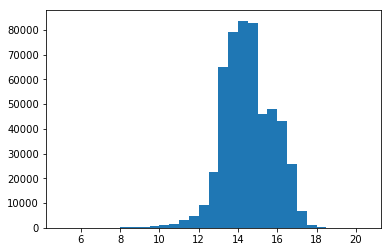

In [131]:
plt.hist(newDF.TESSMAG, bins=np.arange(5,21,0.5))

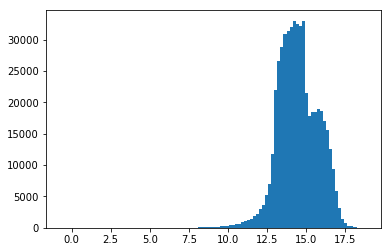

In [149]:
q = plt.hist(newDF.TESSMAG, bins=100)

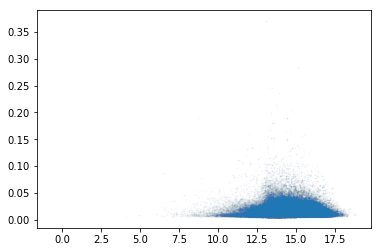

In [152]:
plt.scatter(newDF.TESSMAG, newDF.PRIORITY, s=1, alpha=0.01)

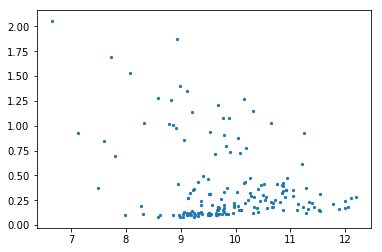

In [167]:
plt.scatter(detected_DF.Ks[detected_DF.planetRadius < 2.0], detected_DF.RADIUS[detected_DF.planetRadius < 2.0], s=5)


In [160]:
detected_DF.loc[(detected_DF.planetRadius < 4.0) & (detected_DF.TESSMAG < 12.0)]z

,Unnamed: 0,RA,DEC,TESSMAG,TEFF,PRIORITY,RADIUS,MASS,CONTRATIO,ECLONG,...,omega,rprs,impact,duration,duration_correction,transit_depth,transit_depth_diluted,needed_for_detection,has_transits,detected
92,940,6.257622,-42.153381,9.443,5728.00,0.021581,1.116950,1.022443,8.191640e-07,345.337419,...,-1.330527,0.022266,0.293454,0.207379,2.230943,495.769435,495.769029,294.941961,True,True
1346,8156,16.703661,26.764952,11.343,3901.00,0.007910,0.588000,0.637000,7.916290e-04,25.863488,...,-1.440444,0.035848,0.090409,0.111131,1.633142,1285.113142,1284.096614,484.307166,True,True
3230,17136,24.463469,-14.721054,11.605,3501.00,0.023052,0.388000,0.402000,5.252487e-05,16.835577,...,-2.499770,0.054564,0.740243,0.064656,1.245690,2977.198738,2977.042370,856.435031,True,True
7256,42471,2.256966,-53.033619,9.645,6209.00,0.041619,1.110030,1.194253,1.372404e-08,333.767597,...,0.557193,0.017923,0.064341,0.187203,2.119641,321.235629,321.235625,203.006399,True,True
42475,219046,42.547788,-26.040588,9.097,5847.00,0.020243,1.168330,1.055361,9.355234e-07,30.041178,...,-2.582389,0.023852,0.870306,0.122250,1.712893,568.908366,568.907833,225.046070,True,True
44725,232576,58.892610,-10.202570,10.066,5483.00,0.016145,1.020820,0.960203,4.261729e-06,54.109278,...,-2.525734,0.027245,0.599693,0.128546,1.756443,742.265970,742.262807,347.664680,True,True
57776,314185,38.499369,-18.197924,11.514,3439.00,0.016349,0.356000,0.361000,3.161386e-04,29.366131,...,-1.143637,0.028772,0.403473,0.035892,0.928127,827.836428,827.574799,752.575921,True,True
89515,505741,69.634873,-76.217911,8.919,4977.00,0.016335,0.847084,0.822452,1.747059e-03,294.559788,...,-2.189417,0.010978,0.481015,0.117607,1.680052,120.507197,120.297032,186.696845,True,True
89978,508172,85.655945,-76.892143,11.949,6095.00,0.007480,1.272460,1.144388,7.750944e-03,275.453208,...,2.620891,0.027027,0.838899,0.157760,1.945828,730.434201,724.816191,703.614996,True,True
90850,512917,89.318848,-56.776299,11.414,5913.00,0.006815,1.188230,1.075942,1.488397e-02,87.804560,...,-2.942016,0.020001,0.724063,0.168366,2.010168,400.055678,394.188588,448.240765,True,True
